In [54]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from einops import rearrange, reduce
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from bliss.cached_dataset import CachedSimulatedDataModule
from case_studies.dc2_mdt.utils.rml_encoder import M2MDTRMLEncoder

In [2]:
model_name = "exp_07-03-1"
model_check_point_name = "encoder_169.ckpt"
model_path = "../../../bliss_output/m2_mdt_full_rml_exp-07-03-1_encoder_169.ckpt"
cached_data_path =  Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./m2_mdt_config", version_base=None):
    cfg = compose("m2_mdt_full_rml_train_config")

In [3]:
seed = cfg.train.seed
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [4]:
batch_size = 800
m2: CachedSimulatedDataModule = instantiate(cfg.cached_simulator)
m2.batch_size = batch_size
m2.setup(stage="validate")
m2_val_dataloader = m2.val_dataloader()

In [5]:
my_encoder: M2MDTRMLEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
my_encoder.load_state_dict(pretrained_weights)
my_encoder.eval();

ddim_sampling_steps = 5
ddim_eta = 0.0
my_encoder.reconfig_sampling(new_sampling_time_steps=ddim_sampling_steps, new_ddim_eta=ddim_eta)

In [6]:
cached_file_name = f"m2_mdt_full_rml_posterior_" \
                        f"{model_name}_{model_check_point_name}_" \
                        f"ddim_steps_{ddim_sampling_steps}_" \
                        f"eta_{ddim_eta:.1f}_" \
                        f"seed_{seed}.pt"
save_path = cached_data_path / cached_file_name
if not os.path.isfile(save_path):
    print(f"can't find cached file [{cached_file_name}]; rerun the inference")
    diffusion_result_dict = {
        "pred_n_sources_list": [],
        "pred_locs_list": [],
        "pred_fluxes_list": [],
        "target1_n_sources_list": [],
        "target1_locs_list": [],
        "target1_fluxes_list": [],
        "target2_n_sources_list": [],
        "target2_locs_list": [],
        "target2_fluxes_list": [],
    }

    for one_batch in tqdm.tqdm(m2_val_dataloader):
        one_batch = move_data_to_device(one_batch, device=device)

        target_tile_cat = TileCatalog(one_batch["tile_catalog"])
        target_cat1 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=0
        )
        target_cat2 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=1
        )
        diffusion_result_dict["target1_n_sources_list"].append(target_cat1["n_sources"].cpu())
        diffusion_result_dict["target1_locs_list"].append(target_cat1["locs"].cpu())
        diffusion_result_dict["target1_fluxes_list"].append(target_cat1["fluxes"].cpu())
        diffusion_result_dict["target2_n_sources_list"].append(target_cat2["n_sources"].cpu())
        diffusion_result_dict["target2_locs_list"].append(target_cat2["locs"].cpu())
        diffusion_result_dict["target2_fluxes_list"].append(target_cat2["fluxes"].cpu())

        with torch.inference_mode():
            sample_tile_cat = my_encoder.sample(one_batch)

        diffusion_result_dict["pred_n_sources_list"].append(sample_tile_cat["n_sources"].cpu())
        diffusion_result_dict["pred_locs_list"].append(sample_tile_cat["locs"].cpu())  # (b, h, w, 2, 2)
        diffusion_result_dict["pred_fluxes_list"].append(sample_tile_cat["fluxes"].cpu())  # (b, h, w, 2, 6)

    torch.save(diffusion_result_dict, save_path)
else:
    print(f"find the cached file [{cached_file_name}]; run nothing")

can't find cached file [m2_mdt_full_rml_posterior_exp_07-03-1_encoder_169.ckpt_ddim_steps_5_eta_0.0_seed_7272.pt]; rerun the inference


100%|██████████| 31/31 [01:30<00:00,  2.92s/it]


In [7]:
for k, v in diffusion_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 1])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])


In [8]:
with open(cached_data_path / "m2_bliss_posterior_exp_07-03-1_encoder_43.ckpt_whole_val_set_seed_7272.pt", "rb") as f:
    bliss_result_dict = torch.load(f, map_location="cpu")

In [9]:
for k, v in bliss_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 1])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])


## N Sources CM

In [39]:
diffusion_true_ns = []
diffusion_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(diffusion_result_dict["target1_n_sources_list"],
                                        diffusion_result_dict["target2_n_sources_list"],
                                        diffusion_result_dict["pred_n_sources_list"],
                                        strict=True):
    diffusion_pred_ns.append(pred_ns)
    diffusion_true_ns.append(true1_ns + true2_ns)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)

In [40]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([24576, 20, 20]), torch.Size([24576, 20, 20]))

In [42]:
bliss_true_ns = []
bliss_pred_ns = []
for true1_ns, true2_ns, pred_ns in zip(bliss_result_dict["target1_n_sources_list"],
                                        bliss_result_dict["target2_n_sources_list"],
                                        bliss_result_dict["pred_n_sources_list"],
                                        strict=True):
    bliss_pred_ns.append(pred_ns)
    bliss_true_ns.append(true1_ns + true2_ns)
bliss_true_ns = torch.cat(bliss_true_ns, dim=0)
bliss_pred_ns = torch.cat(bliss_pred_ns, dim=0)

In [43]:
bliss_true_ns.shape, bliss_pred_ns.shape

(torch.Size([24576, 20, 20]), torch.Size([24576, 20, 20]))

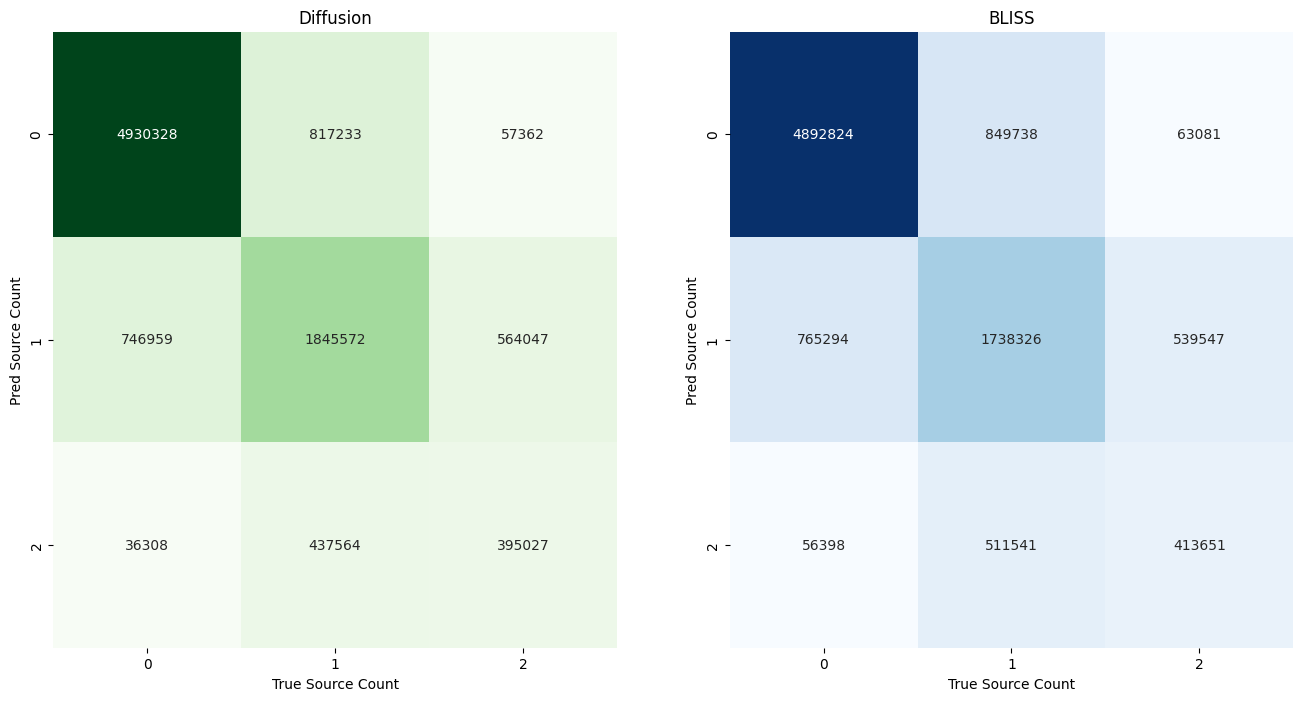

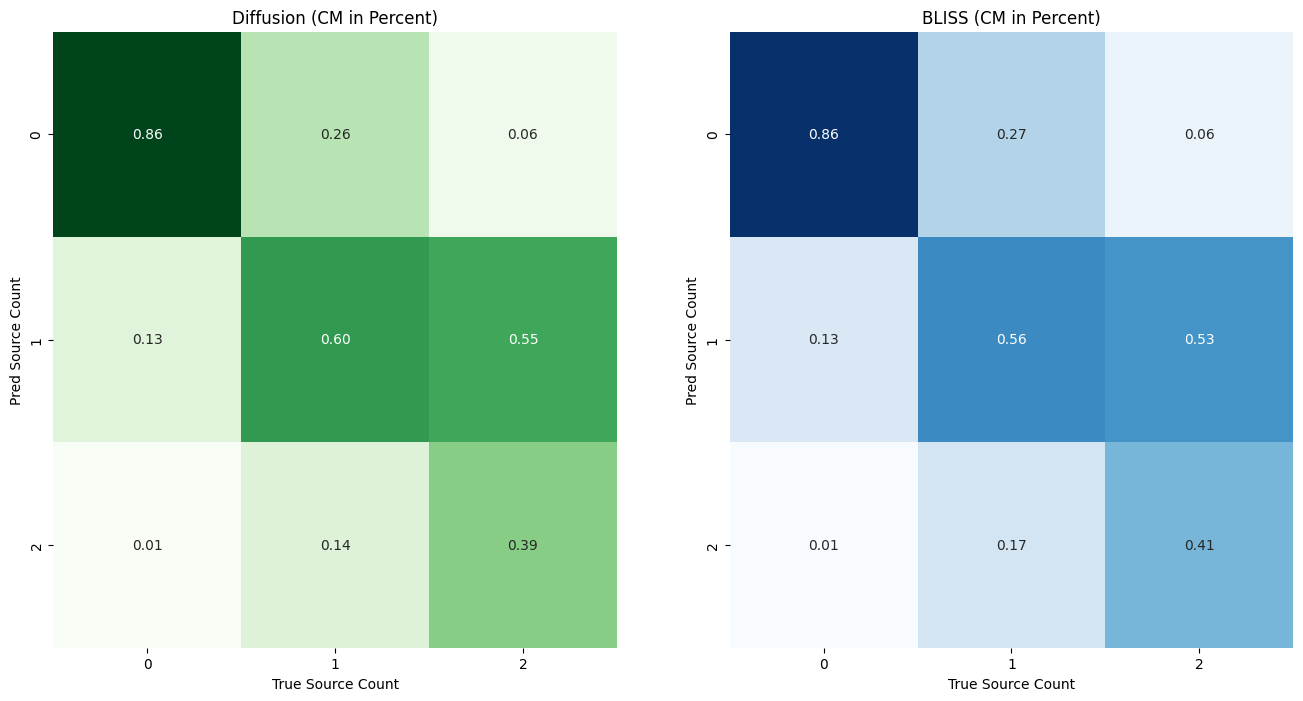

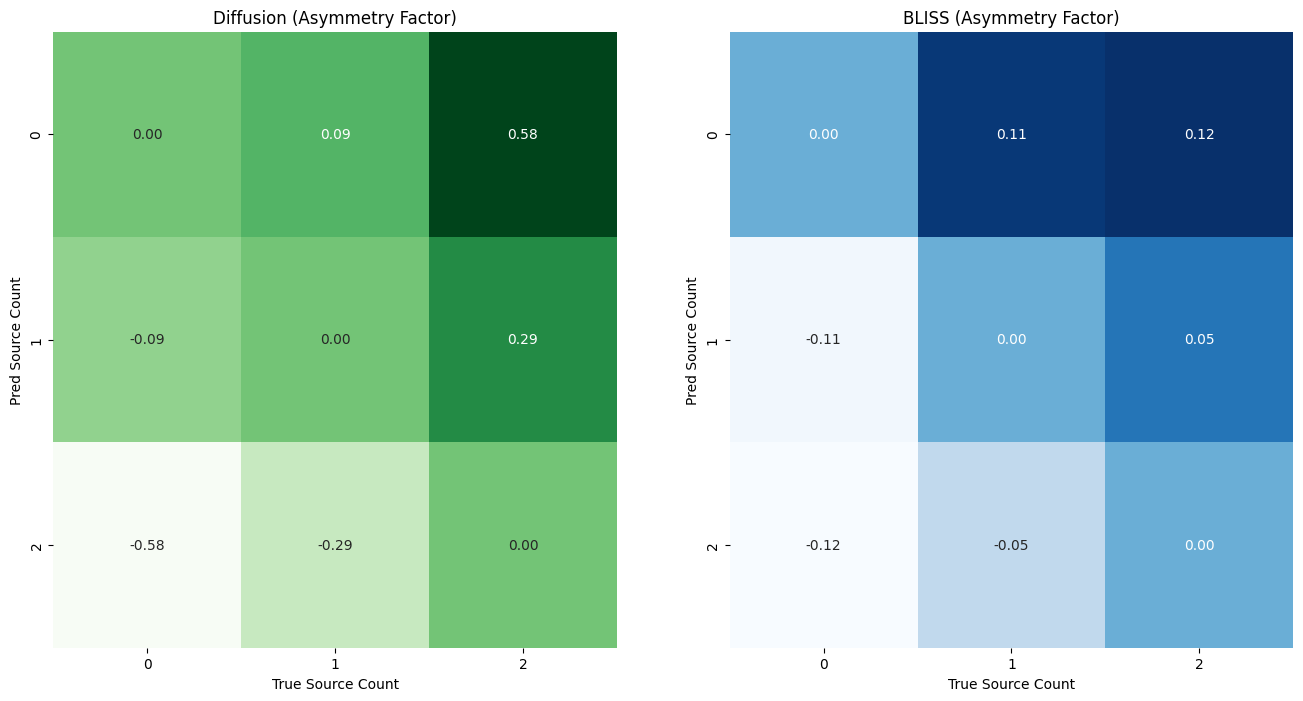

In [45]:
d_cm = torch.zeros(3, 3, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((diffusion_pred_ns == ri) & (diffusion_true_ns == ci)).sum()

b_cm = torch.zeros(3, 3, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((bliss_pred_ns == ri) & (bliss_true_ns == ci)).sum()

bin_labels = [i for i in range(3)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion (Asymmetry Factor)")
sns.heatmap((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()

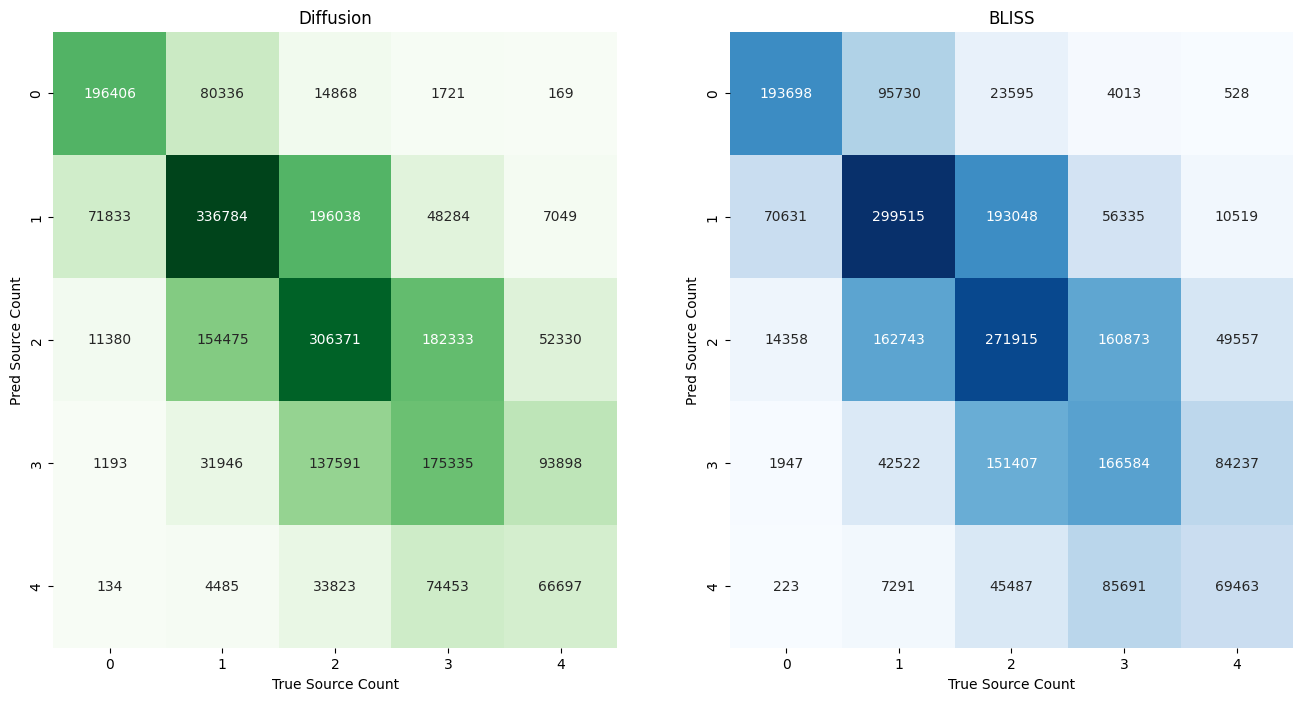

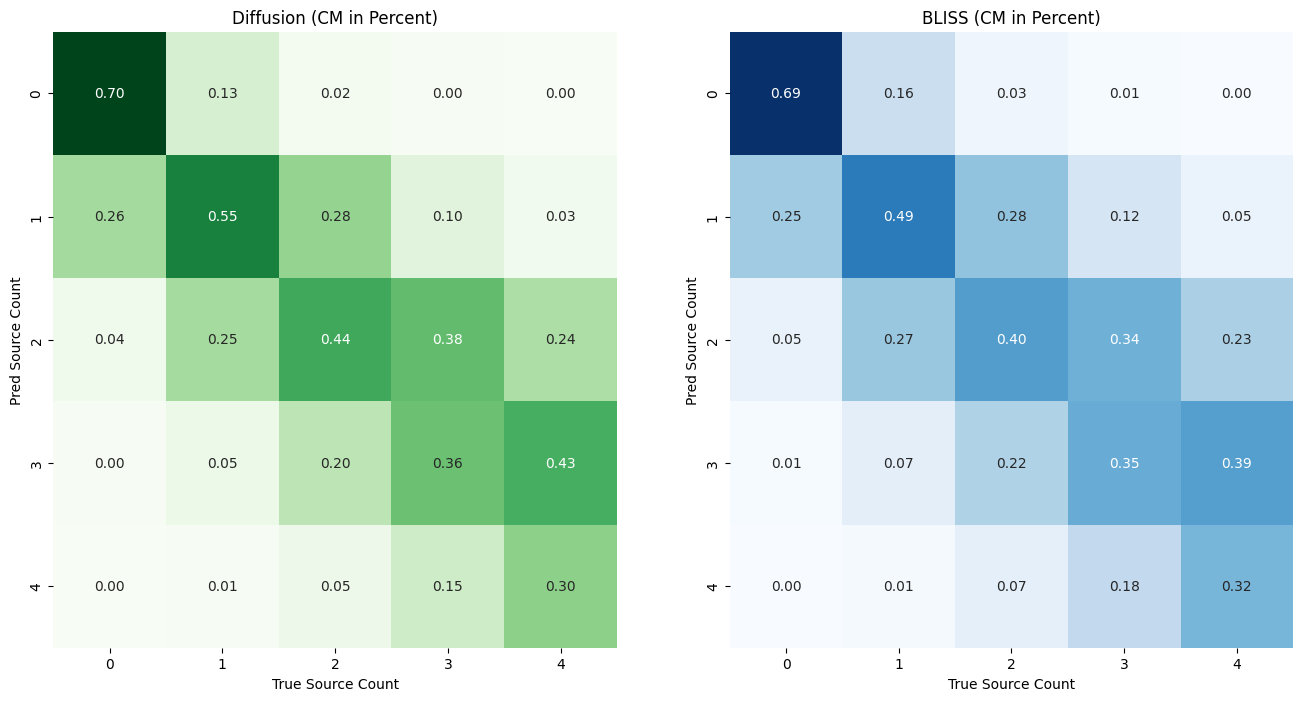

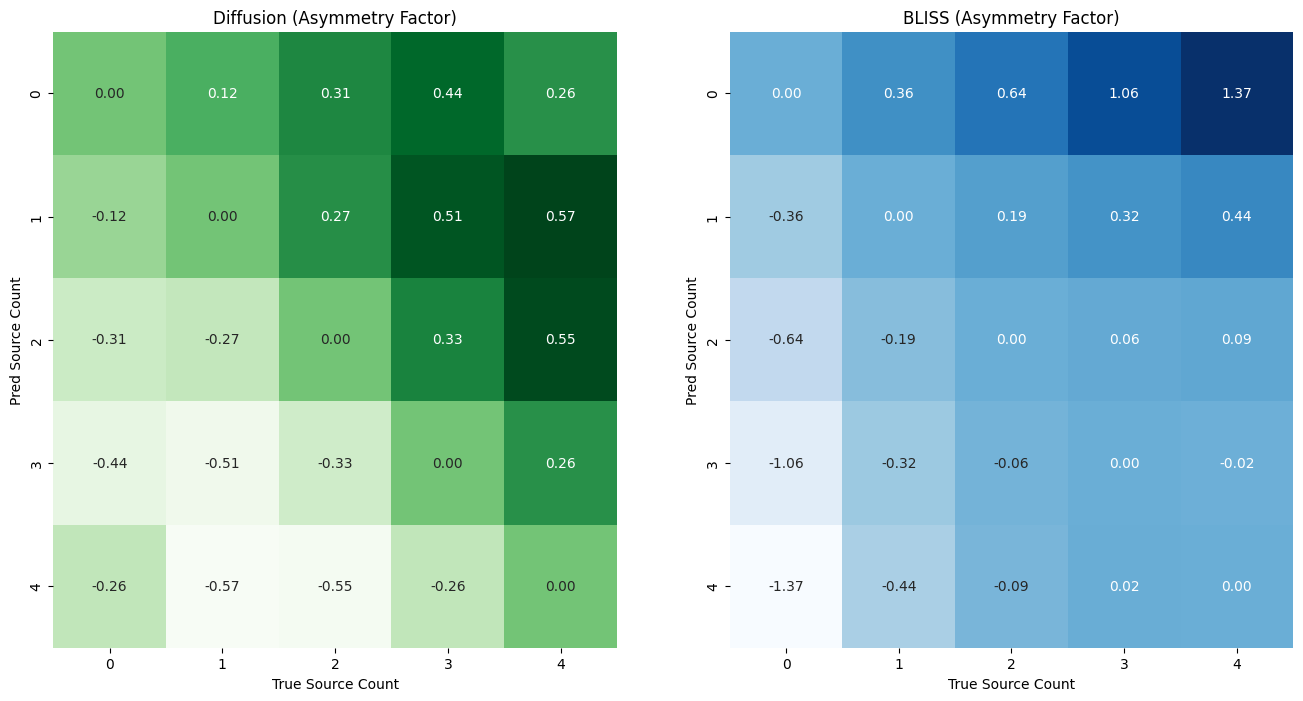

In [56]:
cum_d_pred_ns = reduce(diffusion_pred_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_d_true_ns = reduce(diffusion_true_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_b_pred_ns = reduce(bliss_pred_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
cum_b_true_ns = reduce(bliss_true_ns, "b (h hh) (w ww) -> b h w", hh=2, ww=2, reduction="sum")
d_cm = torch.zeros(5, 5, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((cum_d_pred_ns == ri) & (cum_d_true_ns == ci)).sum()

b_cm = torch.zeros(5, 5, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((cum_b_pred_ns == ri) & (cum_b_true_ns == ci)).sum()

bin_labels = [i for i in range(5)]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Source Count")
axes[0].set_ylabel("Pred Source Count")
axes[0].set_title("Diffusion (Asymmetry Factor)")
sns.heatmap((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Source Count")
axes[1].set_ylabel("Pred Source Count")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()

## Locs Scatter

In [20]:
diffusion_true_locs = []
diffusion_pred_locs = []
for true1_ns, true1_locs, pred_ns, pred_locs in zip(diffusion_result_dict["target1_n_sources_list"],
                                                    diffusion_result_dict["target1_locs_list"],
                                                    diffusion_result_dict["pred_n_sources_list"],
                                                    diffusion_result_dict["pred_locs_list"],
                                                    strict=True):
    one_source_mask = (pred_ns == 1) & (true1_ns > 0)
    diffusion_pred_locs.append(pred_locs[one_source_mask][:, 0, :])
    diffusion_true_locs.append(true1_locs[one_source_mask][:, 0, :])
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)

In [21]:
diffusion_true_locs.shape, diffusion_pred_locs.shape

(torch.Size([2409619, 2]), torch.Size([2409619, 2]))

In [22]:
diffusion_true_locs.min(), diffusion_true_locs.max()

(tensor(0.), tensor(1.0000))

In [23]:
diffusion_pred_locs.min(), diffusion_pred_locs.max()

(tensor(0.), tensor(1.))

In [24]:
def symmetry_deviation_wrt_45d(points: torch.Tensor, sample_n=1000, iters=100):
    min_dists_list = []
    for _ in range(iters):
        sub_points = points[torch.randperm(points.shape[0])[:sample_n], :]
        reflected_points = sub_points[:, [1, 0]]
        diff = reflected_points[:, None, :] - sub_points[None, :, :]
        dists = torch.norm(diff, dim=-1)  # (N, N)
        min_dists = dists.amin(dim=1)  # (N,)
        min_dists_list.append(min_dists.median())
    return torch.stack(min_dists_list, dim=0).median().item()

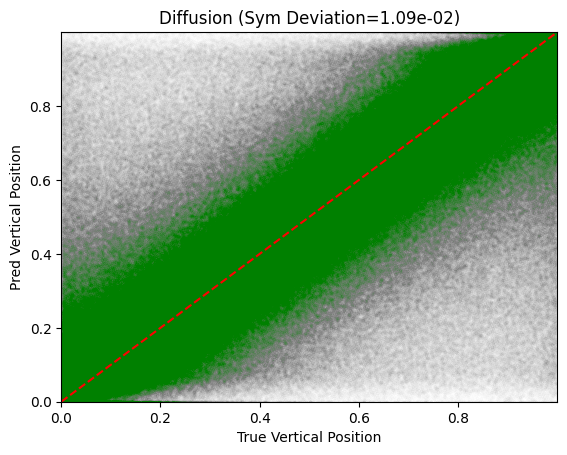

In [33]:
d_pred_locs_y = diffusion_pred_locs[:, 0]
d_true_locs_y = diffusion_true_locs[:, 0]
sym_dev = symmetry_deviation_wrt_45d(torch.stack([d_pred_locs_y, d_true_locs_y], dim=1))
plt.scatter(d_true_locs_y, d_pred_locs_y, 
            s=5, c="green", alpha=0.005)
expect_pts = torch.linspace(d_true_locs_y.min(), d_true_locs_y.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(d_true_locs_y.min(), d_true_locs_y.max())
plt.ylim(d_true_locs_y.min(), d_true_locs_y.max())
plt.xlabel("True Vertical Position")
plt.ylabel("Pred Vertical Position")
plt.title(f"Diffusion (Sym Deviation={sym_dev:.2e})")
plt.show()

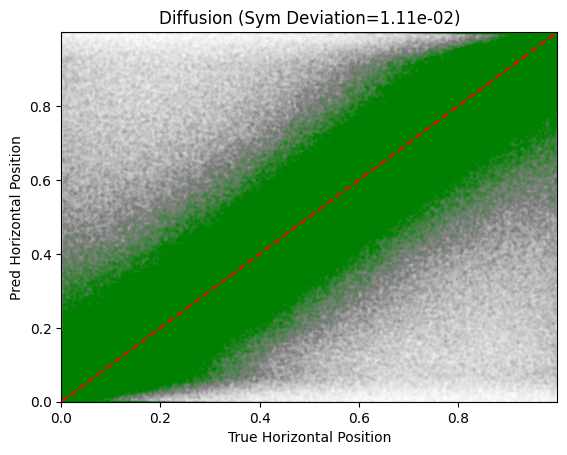

In [35]:
d_pred_locs_x = diffusion_pred_locs[:, 1]
d_true_locs_x = diffusion_true_locs[:, 1]
sym_dev = symmetry_deviation_wrt_45d(torch.stack([d_pred_locs_x, d_true_locs_x], dim=1))
plt.scatter(d_true_locs_x, d_pred_locs_x, 
            s=5, c="green", alpha=0.005)
expect_pts = torch.linspace(d_true_locs_x.min(), d_true_locs_x.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(d_true_locs_x.min(), d_true_locs_x.max())
plt.ylim(d_true_locs_x.min(), d_true_locs_x.max())
plt.xlabel("True Horizontal Position")
plt.ylabel("Pred Horizontal Position")
plt.title(f"Diffusion (Sym Deviation={sym_dev:.2e})")
plt.show()

In [26]:
bliss_true_locs = []
bliss_pred_locs = []
for true1_ns, true1_locs, pred_ns, pred_locs in zip(bliss_result_dict["target1_n_sources_list"],
                                                    bliss_result_dict["target1_locs_list"],
                                                    bliss_result_dict["pred_n_sources_list"],
                                                    bliss_result_dict["pred_locs_list"],
                                                    strict=True):
    one_source_mask = (pred_ns == 1) & (true1_ns > 0)
    bliss_pred_locs.append(pred_locs[one_source_mask][:, 0, :])
    bliss_true_locs.append(true1_locs[one_source_mask][:, 0, :])
bliss_true_locs = torch.cat(bliss_true_locs, dim=0)
bliss_pred_locs = torch.cat(bliss_pred_locs, dim=0)

In [27]:
bliss_true_locs.shape, bliss_pred_locs.shape

(torch.Size([2277873, 2]), torch.Size([2277873, 2]))

In [28]:
bliss_true_locs.min(), bliss_true_locs.max()

(tensor(0.), tensor(1.0000))

In [29]:
bliss_pred_locs.min(), bliss_pred_locs.max()

(tensor(7.0357e-07), tensor(1.0000))

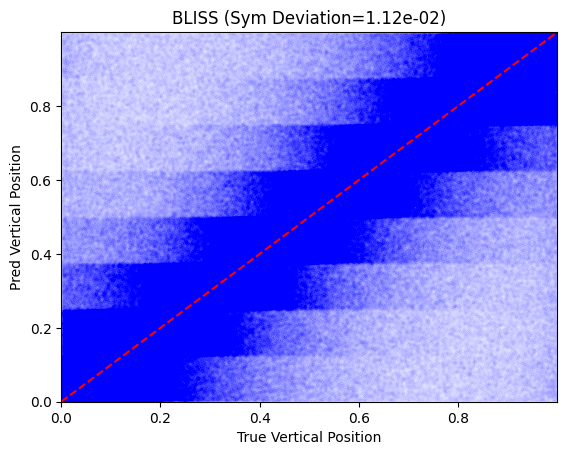

In [36]:
b_pred_locs_y = bliss_pred_locs[:, 0]
b_true_locs_y = bliss_true_locs[:, 0]
sym_dev = symmetry_deviation_wrt_45d(torch.stack([b_pred_locs_y, b_true_locs_y], dim=1))
plt.scatter(b_true_locs_y, b_pred_locs_y, 
            s=5, c="blue", alpha=0.005)
expect_pts = torch.linspace(b_true_locs_y.min(), b_true_locs_y.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(b_true_locs_y.min(), b_true_locs_y.max())
plt.ylim(b_true_locs_y.min(), b_true_locs_y.max())
plt.xlabel("True Vertical Position")
plt.ylabel("Pred Vertical Position")
plt.title(f"BLISS (Sym Deviation={sym_dev:.2e})")
plt.show()

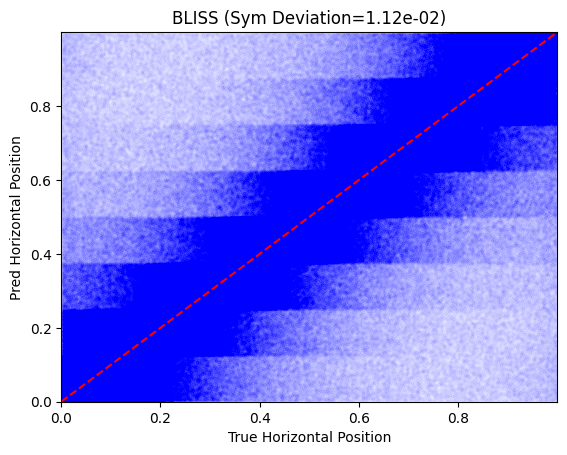

In [37]:
b_pred_locs_x = bliss_pred_locs[:, 1]
b_true_locs_x = bliss_true_locs[:, 1]
sym_dev = symmetry_deviation_wrt_45d(torch.stack([b_pred_locs_x, b_true_locs_x], dim=1))
plt.scatter(b_true_locs_x, b_pred_locs_x, 
            s=5, c="blue", alpha=0.005)
expect_pts = torch.linspace(b_true_locs_x.min(), b_true_locs_x.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(b_true_locs_x.min(), b_true_locs_x.max())
plt.ylim(b_true_locs_x.min(), b_true_locs_x.max())
plt.xlabel("True Horizontal Position")
plt.ylabel("Pred Horizontal Position")
plt.title(f"BLISS (Sym Deviation={sym_dev:.2e})")
plt.show()

## Locs

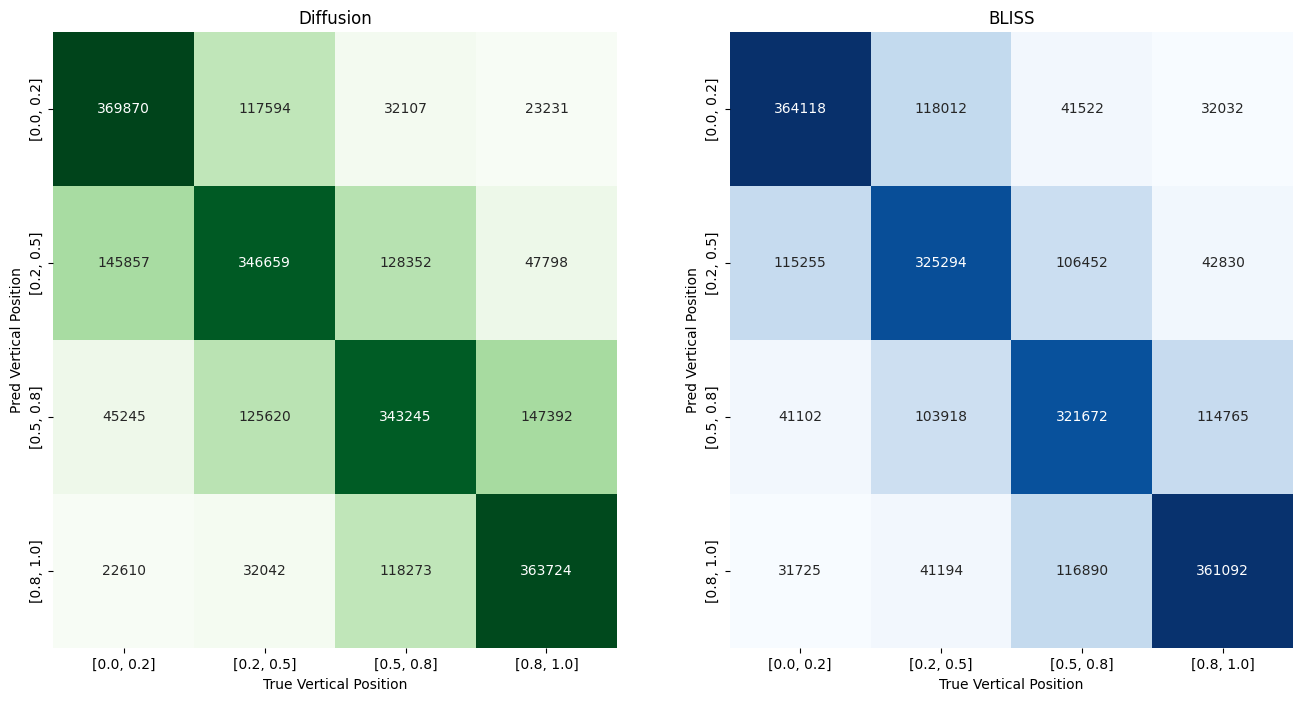

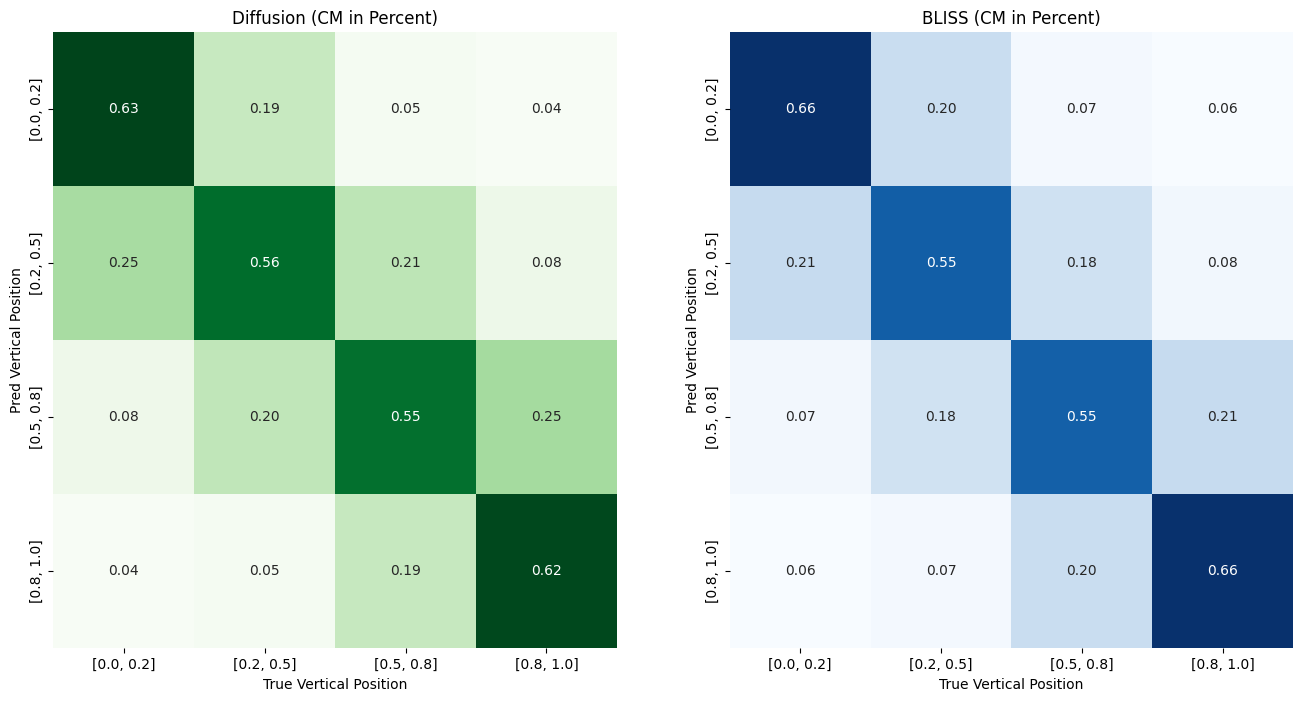

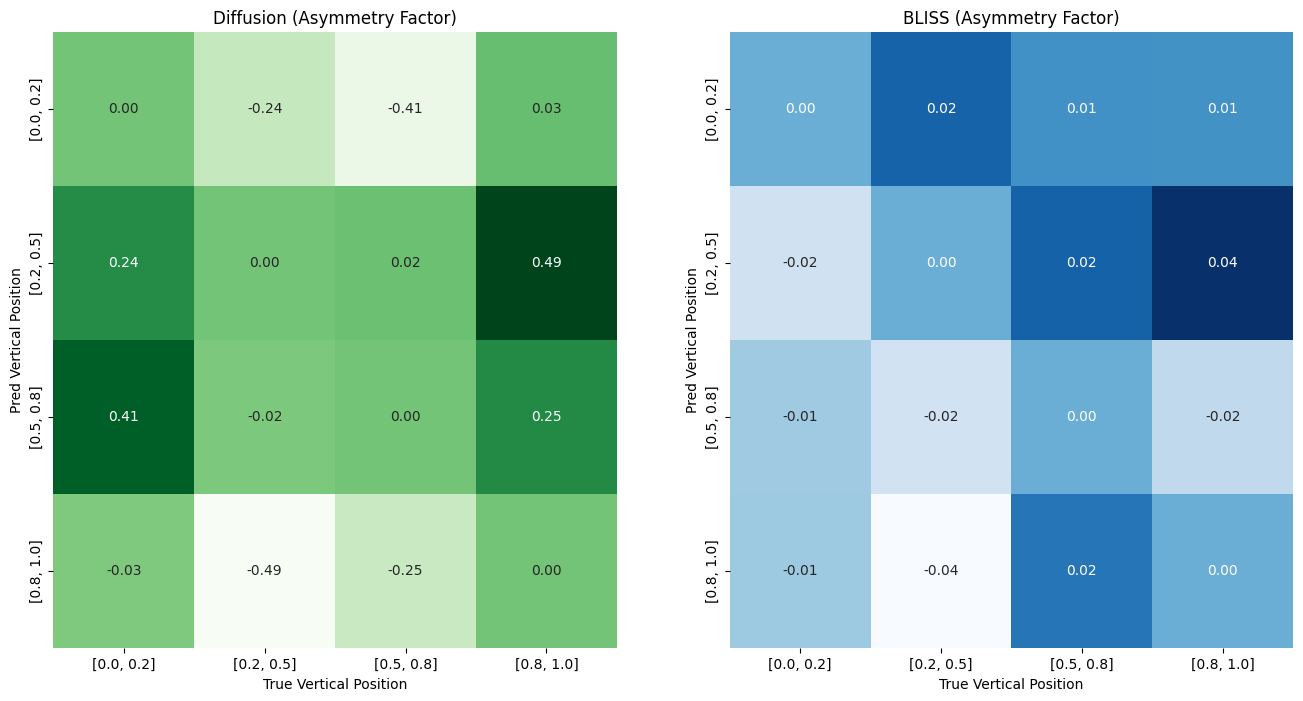

In [52]:
bin_b_num = 4
bin_boundaries = torch.linspace(0.0, 1.0, bin_b_num + 1)
bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))

def bucketize(data, boundaries):
    wide_boundaries = torch.cat([(boundaries[0] - 1e-3).unsqueeze(0), 
                                 boundaries[1:-1], 
                                 (boundaries[-1] + 1e-3).unsqueeze(0)],  dim=0)
    return torch.bucketize(data, wide_boundaries) - 1

d_pred_locs_bin_indexes = bucketize(diffusion_pred_locs[:, 0], bin_boundaries)
d_true_locs_bin_indexes = bucketize(diffusion_true_locs[:, 0], bin_boundaries)
b_pred_locs_bin_indexes = bucketize(bliss_pred_locs[:, 0], bin_boundaries)
b_true_locs_bin_indexes = bucketize(bliss_true_locs[:, 0], bin_boundaries)

d_cm = torch.zeros(bin_b_num, bin_b_num, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((d_pred_locs_bin_indexes == ri) & (d_true_locs_bin_indexes == ci)).sum()

b_cm = torch.zeros(bin_b_num, bin_b_num, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((b_pred_locs_bin_indexes == ri) & (b_true_locs_bin_indexes == ci)).sum()

bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Vertical Position")
axes[0].set_ylabel("Pred Vertical Position")
axes[0].set_title("Diffusion")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Vertical Position")
axes[1].set_ylabel("Pred Vertical Position")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Vertical Position")
axes[0].set_ylabel("Pred Vertical Position")
axes[0].set_title("Diffusion (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Vertical Position")
axes[1].set_ylabel("Pred Vertical Position")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Vertical Position")
axes[0].set_ylabel("Pred Vertical Position")
axes[0].set_title("Diffusion (Asymmetry Factor)")
sns.heatmap((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Vertical Position")
axes[1].set_ylabel("Pred Vertical Position")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()

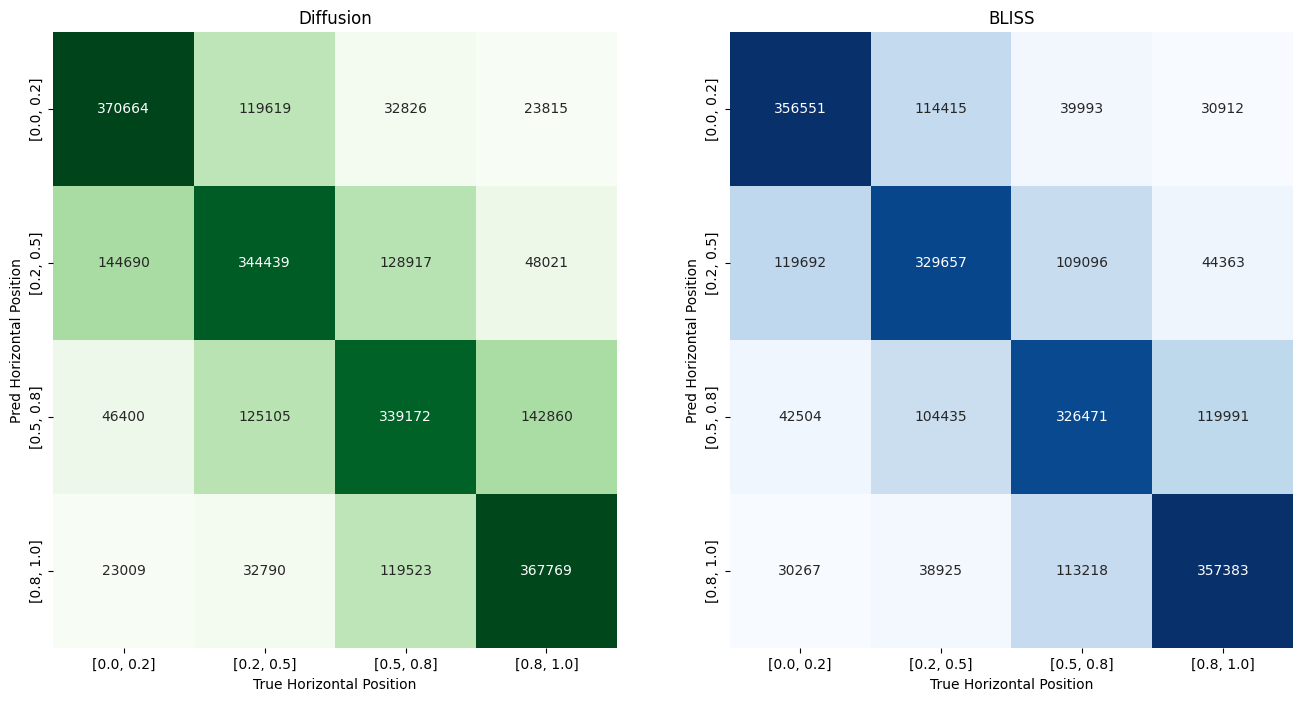

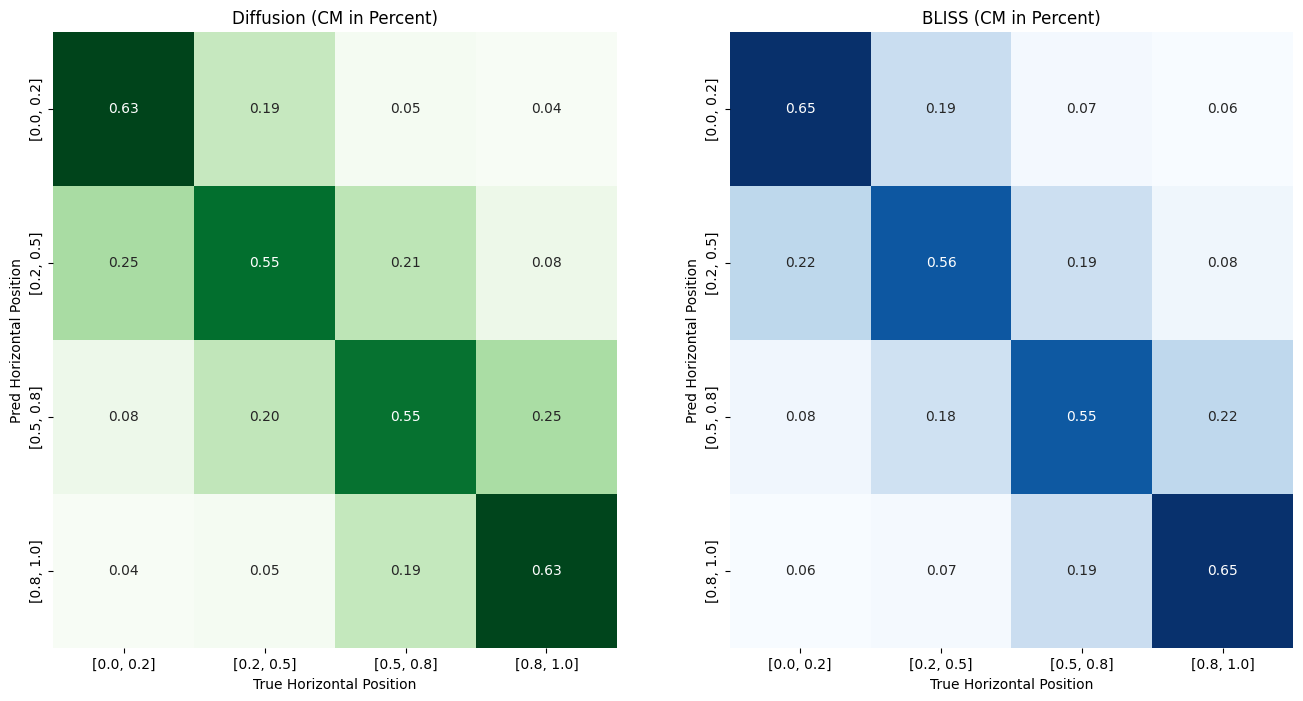

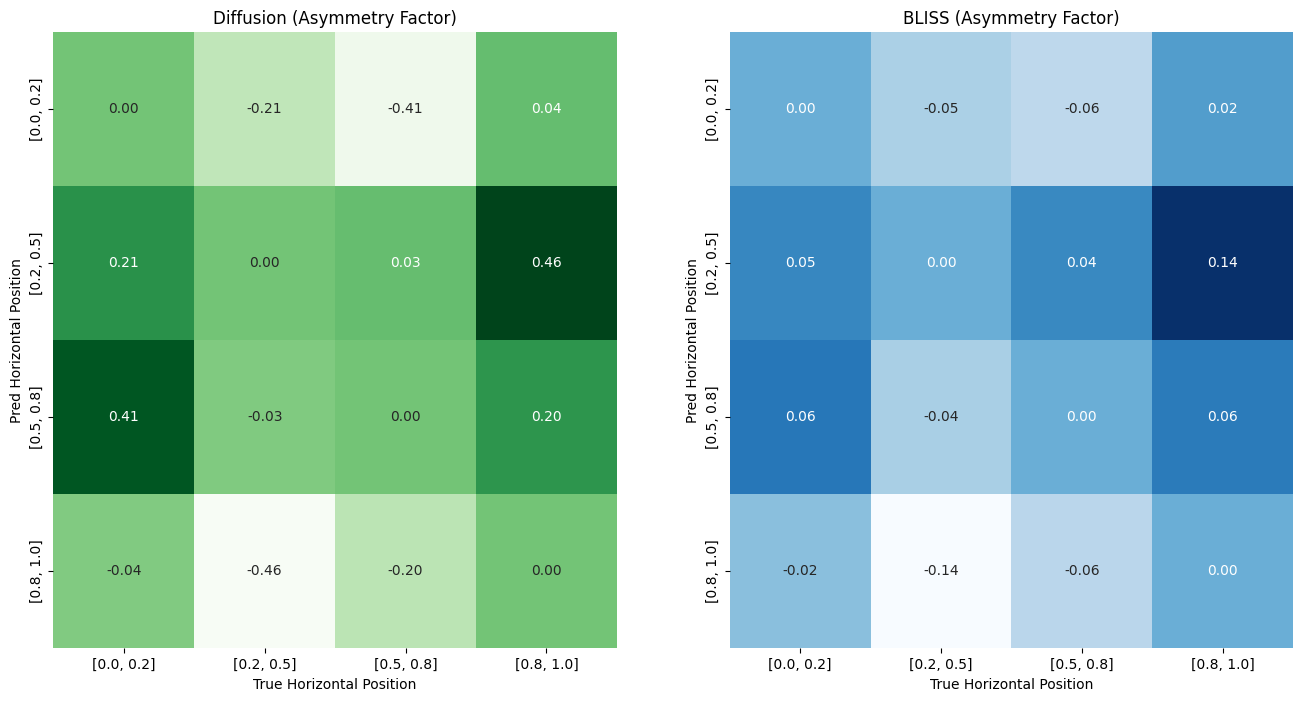

In [53]:
bin_b_num = 4
bin_boundaries = torch.linspace(0.0, 1.0, bin_b_num + 1)
bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))

def bucketize(data, boundaries):
    wide_boundaries = torch.cat([(boundaries[0] - 1e-3).unsqueeze(0), 
                                 boundaries[1:-1], 
                                 (boundaries[-1] + 1e-3).unsqueeze(0)],  dim=0)
    return torch.bucketize(data, wide_boundaries) - 1

d_pred_locs_bin_indexes = bucketize(diffusion_pred_locs[:, 1], bin_boundaries)
d_true_locs_bin_indexes = bucketize(diffusion_true_locs[:, 1], bin_boundaries)
b_pred_locs_bin_indexes = bucketize(bliss_pred_locs[:, 1], bin_boundaries)
b_true_locs_bin_indexes = bucketize(bliss_true_locs[:, 1], bin_boundaries)

d_cm = torch.zeros(bin_b_num, bin_b_num, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((d_pred_locs_bin_indexes == ri) & (d_true_locs_bin_indexes == ci)).sum()

b_cm = torch.zeros(bin_b_num, bin_b_num, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((b_pred_locs_bin_indexes == ri) & (b_true_locs_bin_indexes == ci)).sum()

bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Horizontal Position")
axes[0].set_ylabel("Pred Horizontal Position")
axes[0].set_title("Diffusion")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Horizontal Position")
axes[1].set_ylabel("Pred Horizontal Position")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Horizontal Position")
axes[0].set_ylabel("Pred Horizontal Position")
axes[0].set_title("Diffusion (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Horizontal Position")
axes[1].set_ylabel("Pred Horizontal Position")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Horizontal Position")
axes[0].set_ylabel("Pred Horizontal Position")
axes[0].set_title("Diffusion (Asymmetry Factor)")
sns.heatmap((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Horizontal Position")
axes[1].set_ylabel("Pred Horizontal Position")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()